In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import os
import glob
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import random
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [45]:
PROJECT_ROOT = "/content/drive/MyDrive/COS429/final_project"
DATASET_ROOT = os.path.join(PROJECT_ROOT, "PnPLO Dataset")

In [46]:
def get_split_dirs(split):
    """
    split: 'train', 'val', or 'test'
    Returns: (images_dir, annots_dir, list_file)
    """
    # Adjust for capitalized 'Train' directory
    if split == 'train':
        split_root = os.path.join(DATASET_ROOT, 'Train')
    elif split == 'val':
        split_root = os.path.join(DATASET_ROOT, 'Val')
    else:
        split_root = os.path.join(DATASET_ROOT, 'Test')

    images_dir = os.path.join(split_root, "JPEGImages")
    annots_dir = os.path.join(split_root, "Annotations")
    list_file  = os.path.join(split_root, f"{split}.txt")
    return images_dir, annots_dir, list_file

for s in ["train", "val", "test"]:
    images_dir, annots_dir, list_file = get_split_dirs(s)
    print(f"{s} images dir:    {images_dir}")
    print(f"{s} annots dir:    {annots_dir}")
    print(f"{s} list file:     {list_file}")
    print()

RESULTS_DIR = os.path.join(PROJECT_ROOT, "results_hog")
os.makedirs(RESULTS_DIR, exist_ok=True)
print("Results will be saved to:", RESULTS_DIR)

train images dir:    /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Train/JPEGImages
train annots dir:    /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Train/Annotations
train list file:     /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Train/train.txt

val images dir:    /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Val/JPEGImages
val annots dir:    /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Val/Annotations
val list file:     /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Val/val.txt

test images dir:    /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Test/JPEGImages
test annots dir:    /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Test/Annotations
test list file:     /content/drive/MyDrive/COS429/final_project/PnPLO Dataset/Test/test.txt

Results will be saved to: /content/drive/MyDrive/COS429/final_project/results_hog


In [47]:
def parse_annotation(xml_path):
    """
    Parse a VOC-style XML file.

    Returns list of dicts:
      [{ 'bbox': (xmin,ymin,xmax,ymax), 'label': str }, ...]
    NOTE: we intentionally *do not* trust <filename> in the XML,
    because in your dataset it is something like 'image (7).xml'.
    """
    import xml.etree.ElementTree as ET

    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text.lower().strip()
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        objects.append({
            'label': name,
            'bbox': (xmin, ymin, xmax, ymax),
        })
    return objects


In [48]:
# Adjust once you see all labels in your data
person_labels    = {'person'}       # human
nonperson_labels = {'nonhuman'}     # tweak if you have other non-human labels

def map_label_to_binary(name):
    """
    Returns 1 for person, 0 for non-person, or None to ignore.
    """
    name = name.lower()
    if name in person_labels:
        return 1
    if name in nonperson_labels:
        return 0
    return None  # ignore anything else


def resolve_image_path(images_dir, base_id):
    """
    Try common extensions to find the actual image file for a given ID.
    base_id is like 'image (7)' from train.txt / val.txt / test.txt.
    """
    exts = [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]
    for ext in exts:
        candidate = os.path.join(images_dir, base_id + ext)
        if os.path.exists(candidate):
            return candidate
    return None


def load_split_samples(split):
    """
    Load all bounding boxes for a given split ('train', 'val', 'test').

    Returns: list of dicts with keys:
      'img_path', 'bbox', 'label', 'y', 'split'
    """
    images_dir, annots_dir, list_file = get_split_dirs(split)

    # Load list of image IDs from txt file (e.g. 'image (7)')
    with open(list_file, 'r') as f:
        ids = [line.strip() for line in f if line.strip()]

    samples = []
    for img_id in ids:
        base = os.path.splitext(img_id)[0]  # strip extension if present
        xml_path = os.path.join(annots_dir, base + ".xml")
        if not os.path.exists(xml_path):
            print(f"[{split}] Warning: XML not found for", xml_path)
            continue

        objs = parse_annotation(xml_path)

        # Resolve image path using base id (ignore XML filename)
        img_path = resolve_image_path(images_dir, base)
        if img_path is None:
            print(f"[{split}] Warning: no image found for ID '{base}'")
            continue

        for o in objs:
            y = map_label_to_binary(o['label'])
            if y is None:
                continue  # skip labels we don't care about

            samples.append({
                'img_path': img_path,
                'bbox': o['bbox'],
                'label': o['label'],
                'y': y,
                'split': split,
            })

    print(f"{split}: loaded {len(samples)} labeled boxes")
    print(f"  positives (person):     {sum(s['y'] == 1 for s in samples)}")
    print(f"  negatives (non-person): {sum(s['y'] == 0 for s in samples)}")
    return samples


In [49]:
train_samples = load_split_samples("train")
val_samples   = load_split_samples("val")
test_samples  = load_split_samples("test")

labels_in_data = sorted({s['label'] for s in (train_samples + val_samples + test_samples)})
print("Labels present across all splits:", labels_in_data)

[train] Warning: no image found for ID 'img (106)'
[train] Warning: no image found for ID 'img (112)'
[train] Warning: no image found for ID 'img (128)'
[train] Warning: no image found for ID 'img (223)'
[train] Warning: no image found for ID 'img (243)'
[train] Warning: no image found for ID 'img (327)'
[train] Warning: no image found for ID 'img (361)'
[train] Warning: no image found for ID 'img (386)'
[train] Warning: no image found for ID 'img (388)'
[train] Warning: no image found for ID 'img (420)'
[train] Warning: no image found for ID 'img (433)'
[train] Warning: no image found for ID 'img (437)'
[train] Warning: no image found for ID 'img (444)'
[train] Warning: no image found for ID 'img (451)'
[train] Warning: no image found for ID 'img (454)'
[train] Warning: no image found for ID 'img (470)'
[train] Warning: no image found for ID 'img (568)'
[train] Warning: no image found for ID 'img (575)'
[train] Warning: no image found for ID 'img (580)'
[train] Warning: no image found

### We're missing a few images, idk if it's a big deal. still have enough.

In [50]:
images_dir, annots_dir, list_file = get_split_dirs("train")
print(sorted(os.listdir(images_dir))[:20])  # peek

['2008_000008.jpg', '2008_000036.jpg', '2008_000041.jpg', '2008_000096.jpg', '2008_000109.jpg', '2008_000128.jpg', '2008_000132.jpg', '2008_000142.jpg', '2008_000143.jpg', '2008_000144.jpg', '2008_000176.jpg', '2008_000199.jpg', '2008_000202.jpg', '2008_000207.jpg', '2008_000217.jpg', '2008_000235.jpg', '2008_000236.jpg', '2008_000252.jpg', '2008_000259.jpg', '2008_000260.jpg']


In [51]:
images_dir, annots_dir, list_file = get_split_dirs("train")
[f for f in os.listdir(images_dir) if f.startswith("img (")]  # should return many files if fully present


['img (105).jpg',
 'img (107).jpg',
 'img (103).jpg',
 'img (101).jpg',
 'img (102).jpg',
 'img (100).jpg',
 'img (104).jpg',
 'img (108).jpg',
 'img (109).jpg',
 'img (117).jpg',
 'img (119).jpg',
 'img (116).jpg',
 'img (110).jpg',
 'img (113).jpg',
 'img (118).jpg',
 'img (111).jpg',
 'img (114).jpg',
 'img (115).jpg',
 'img (120).jpg',
 'img (121).jpg',
 'img (122).jpg',
 'img (123).jpg',
 'img (124).jpg',
 'img (132).jpg',
 'img (134).jpg',
 'img (125).jpg',
 'img (126).jpg',
 'img (129).jpg',
 'img (133).jpg',
 'img (131).jpg',
 'img (130).jpg',
 'img (135).jpg',
 'img (136).jpg',
 'img (138).jpg',
 'img (137).jpg',
 'img (145).jpg',
 'img (144).jpg',
 'img (139).jpg',
 'img (143).jpg',
 'img (146).jpg',
 'img (140).jpg',
 'img (142).jpg',
 'img (141).jpg',
 'img (148).jpg',
 'img (147).jpg',
 'img (151).jpg',
 'img (156).jpg',
 'img (157).jpg',
 'img (155).jpg',
 'img (154).jpg',
 'img (152).jpg',
 'img (149).jpg',
 'img (153).jpg',
 'img (150).jpg',
 'img (159).jpg',
 'img (158

In [52]:
images_dir, annots_dir, list_file = get_split_dirs("train")

# IDs from train.txt (strip extensions/whitespace)
with open(list_file, "r") as f:
    ids = [os.path.splitext(line.strip())[0] for line in f if line.strip()]

# Base names from actual files
files = [os.path.splitext(f)[0] for f in os.listdir(images_dir)]
files_set = set(files)

missing = sorted([i for i in ids if i not in files_set])
print("Missing image IDs in train:", missing, " (count:", len(missing), ")")

Missing image IDs in train: ['img (106)', 'img (112)', 'img (128)', 'img (223)', 'img (243)', 'img (327)', 'img (361)', 'img (386)', 'img (388)', 'img (420)', 'img (433)', 'img (437)', 'img (444)', 'img (451)', 'img (454)', 'img (470)', 'img (568)', 'img (575)', 'img (580)', 'img (581)', 'img (590)']  (count: 21 )


### HOG (Dalal & Triggs)

In [53]:
import cv2
import numpy as np

# HOG parameters (Dalal & Triggs-style)
WIN_SIZE     = (64, 128)  # (width, height)
BLOCK_SIZE   = (16, 16)
BLOCK_STRIDE = (8, 8)
CELL_SIZE    = (8, 8)
NBINS        = 9

hog = cv2.HOGDescriptor(WIN_SIZE, BLOCK_SIZE, BLOCK_STRIDE, CELL_SIZE, NBINS)

def compute_hog_feature(img):
    """
    img: BGR or grayscale image (np.uint8)
    returns: 1D numpy array of HOG features
    """
    if img is None:
        raise ValueError("compute_hog_feature: got None image")

    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Resize crop to fixed HOG window
    resized = cv2.resize(gray, WIN_SIZE)
    feat = hog.compute(resized)  # column vector
    return feat.flatten()


In [54]:
import os
import numpy as np

def build_features(samples, split_name):
    """
    Given list of samples with keys:
      'img_path', 'bbox', 'y'
    compute HOG features for each bounding box.
    """
    X_list = []
    y_list = []

    for i, s in enumerate(samples):
        img = cv2.imread(s['img_path'])
        if img is None:
            print(f"[{split_name}] Warning: could not read {s['img_path']}")
            continue

        xmin, ymin, xmax, ymax = s['bbox']
        h, w = img.shape[:2]

        # Clamp to image bounds
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w - 1, xmax)
        ymax = min(h - 1, ymax)
        if xmax <= xmin or ymax <= ymin:
            continue

        crop = img[ymin:ymax, xmin:xmax]
        feat = compute_hog_feature(crop)

        X_list.append(feat)
        y_list.append(s['y'])   # 1 = person, 0 = nonhuman

        if (i + 1) % 200 == 0:
            print(f"[{split_name}] processed {i+1}/{len(samples)} boxes")

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)
    print(f"[{split_name}] X shape: {X.shape}, y shape: {y.shape}")
    print(f"[{split_name}] persons: {np.sum(y==1)}, nonhumans: {np.sum(y==0)}")
    return X, y

X_train, y_train = build_features(train_samples, "train")
X_val,   y_val   = build_features(val_samples,   "val")
X_test,  y_test  = build_features(test_samples,  "test")

# Optionally save for future runs
np.save(os.path.join(RESULTS_DIR, "hog_X_train.npy"), X_train)
np.save(os.path.join(RESULTS_DIR, "hog_y_train.npy"), y_train)
np.save(os.path.join(RESULTS_DIR, "hog_X_val.npy"),   X_val)
np.save(os.path.join(RESULTS_DIR, "hog_y_val.npy"),   y_val)
np.save(os.path.join(RESULTS_DIR, "hog_X_test.npy"),  X_test)
np.save(os.path.join(RESULTS_DIR, "hog_y_test.npy"),  y_test)

[train] processed 200/2017 boxes
[train] processed 400/2017 boxes
[train] processed 600/2017 boxes
[train] processed 800/2017 boxes
[train] processed 1000/2017 boxes
[train] processed 1200/2017 boxes
[train] processed 1400/2017 boxes
[train] processed 1600/2017 boxes
[train] processed 1800/2017 boxes
[train] processed 2000/2017 boxes
[train] X shape: (2017, 3780), y shape: (2017,)
[train] persons: 1103, nonhumans: 914
[val] processed 200/325 boxes
[val] X shape: (325, 3780), y shape: (325,)
[val] persons: 199, nonhumans: 126
[test] processed 200/577 boxes
[test] processed 400/577 boxes
[test] X shape: (577, 3780), y shape: (577,)
[test] persons: 316, nonhumans: 261


In [55]:
from sklearn.svm import LinearSVC

clf = LinearSVC(
    C=0.01,             # you can tune this with val
    class_weight='balanced',
    max_iter=5000
)

clf.fit(X_train, y_train)

import joblib
joblib.dump(clf, os.path.join(RESULTS_DIR, "hog_linear_svm.joblib"))
print("Model saved to:", os.path.join(RESULTS_DIR, "hog_linear_svm.joblib"))

Model saved to: /content/drive/MyDrive/COS429/final_project/results_hog/hog_linear_svm.joblib


In [56]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_split(X, y, split_name):
    y_pred = clf.predict(X)

    print(f"\n=== {split_name.upper()} RESULTS ===")
    print("Confusion matrix (rows = true, cols = pred):")
    print(confusion_matrix(y, y_pred))

    print("\nClassification report:")
    print(classification_report(
        y, y_pred,
        target_names=["nonhuman", "person"]
    ))

    # False positives: nonhuman (0) predicted as person (1)
    nonhuman_idx = (y == 0)
    nonhuman_true = y[nonhuman_idx]
    nonhuman_pred = y_pred[nonhuman_idx]

    fp_count = np.sum(nonhuman_pred == 1)
    nonhuman_total = nonhuman_true.shape[0]
    fp_rate = fp_count / nonhuman_total if nonhuman_total > 0 else 0.0

    print(f"False positive rate (nonhuman misclassified as person): "
          f"{fp_rate:.4f} ({fp_count}/{nonhuman_total})")

    return y_pred

y_pred_train = evaluate_split(X_train, y_train, "train")
y_pred_val   = evaluate_split(X_val,   y_val,   "val")
y_pred_test  = evaluate_split(X_test,  y_test,  "test")



=== TRAIN RESULTS ===
Confusion matrix (rows = true, cols = pred):
[[770 144]
 [121 982]]

Classification report:
              precision    recall  f1-score   support

    nonhuman       0.86      0.84      0.85       914
      person       0.87      0.89      0.88      1103

    accuracy                           0.87      2017
   macro avg       0.87      0.87      0.87      2017
weighted avg       0.87      0.87      0.87      2017

False positive rate (nonhuman misclassified as person): 0.1575 (144/914)

=== VAL RESULTS ===
Confusion matrix (rows = true, cols = pred):
[[ 90  36]
 [ 57 142]]

Classification report:
              precision    recall  f1-score   support

    nonhuman       0.61      0.71      0.66       126
      person       0.80      0.71      0.75       199

    accuracy                           0.71       325
   macro avg       0.70      0.71      0.71       325
weighted avg       0.73      0.71      0.72       325

False positive rate (nonhuman misclassified a

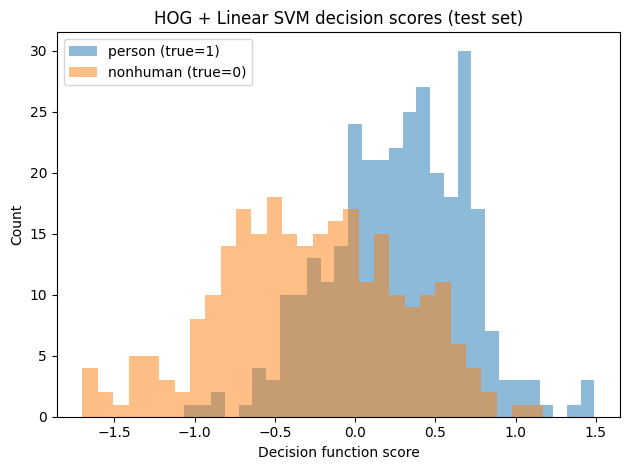

In [57]:
import matplotlib.pyplot as plt

scores_test = clf.decision_function(X_test)

plt.figure()
plt.hist(scores_test[y_test == 1], bins=30, alpha=0.5, label='person (true=1)')
plt.hist(scores_test[y_test == 0], bins=30, alpha=0.5, label='nonhuman (true=0)')
plt.xlabel("Decision function score")
plt.ylabel("Count")
plt.legend()
plt.title("HOG + Linear SVM decision scores (test set)")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "hog_svm_scores_test.png"), dpi=200)
plt.show()


In [58]:
import matplotlib.pyplot as plt

def build_features_with_meta(samples, split_name):
    """
    Like build_features, but also returns metadata list aligned with rows in X:
    meta[i] = sample dict with img_path, bbox, label, y, split
    """
    X_list = []
    y_list = []
    meta_list = []

    for i, s in enumerate(samples):
        img = cv2.imread(s['img_path'])
        if img is None:
            print(f"[{split_name}] Warning: could not read {s['img_path']}")
            continue

        xmin, ymin, xmax, ymax = s['bbox']
        h, w = img.shape[:2]

        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w - 1, xmax)
        ymax = min(h - 1, ymax)
        if xmax <= xmin or ymax <= ymin:
            continue

        crop = img[ymin:ymax, xmin:xmax]
        feat = compute_hog_feature(crop)

        X_list.append(feat)
        y_list.append(s['y'])
        meta_list.append(s)   # keep full sample dict

        if (i + 1) % 200 == 0:
            print(f"[{split_name}] (vis) processed {i+1}/{len(samples)} boxes")

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)
    print(f"[{split_name} VIS] X shape: {X.shape}, y shape: {y.shape}")
    print(f"[{split_name} VIS] persons: {np.sum(y==1)}, nonhumans: {np.sum(y==0)}")
    return X, y, meta_list

X_vis, y_vis, meta_vis = build_features_with_meta(test_samples, "test")
y_pred_vis = clf.predict(X_vis)


[test] (vis) processed 200/577 boxes
[test] (vis) processed 400/577 boxes
[test VIS] X shape: (577, 3780), y shape: (577,)
[test VIS] persons: 316, nonhumans: 261


In [59]:
def show_crops(indices, title, max_n=8):
    """
    indices: list/array of indices into meta_vis / y_vis / y_pred_vis
    Shows up to max_n crops with GT + predicted label.
    """
    n = min(max_n, len(indices))
    if n == 0:
        print(f"No examples for: {title}")
        return

    ncols = 4
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(4 * ncols, 4 * nrows))
    for i, idx in enumerate(indices[:n]):
        s = meta_vis[idx]
        img = cv2.imread(s['img_path'])
        xmin, ymin, xmax, ymax = s['bbox']
        h, w = img.shape[:2]
        xmin = max(0, xmin); ymin = max(0, ymin)
        xmax = min(w - 1, xmax); ymax = min(h - 1, ymax)
        crop = img[ymin:ymax, xmin:xmax]

        # convert BGR → RGB for matplotlib
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

        gt = "person" if y_vis[idx] == 1 else "nonhuman"
        pred = "person" if y_pred_vis[idx] == 1 else "nonhuman"

        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(crop_rgb)
        ax.axis("off")
        ax.set_title(f"GT: {gt}\nPred: {pred}", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


TP count: 236
FP count: 86
FN count: 80
TN count: 175


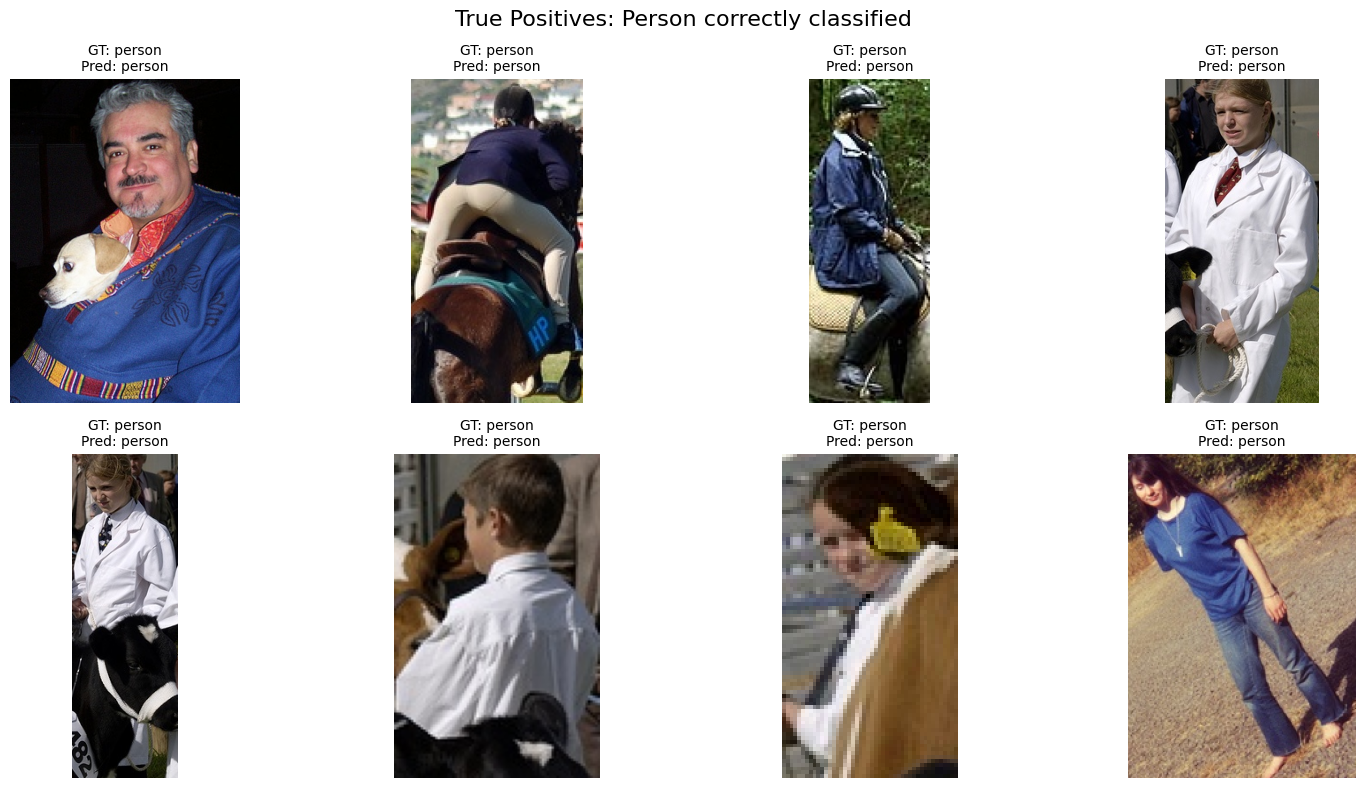

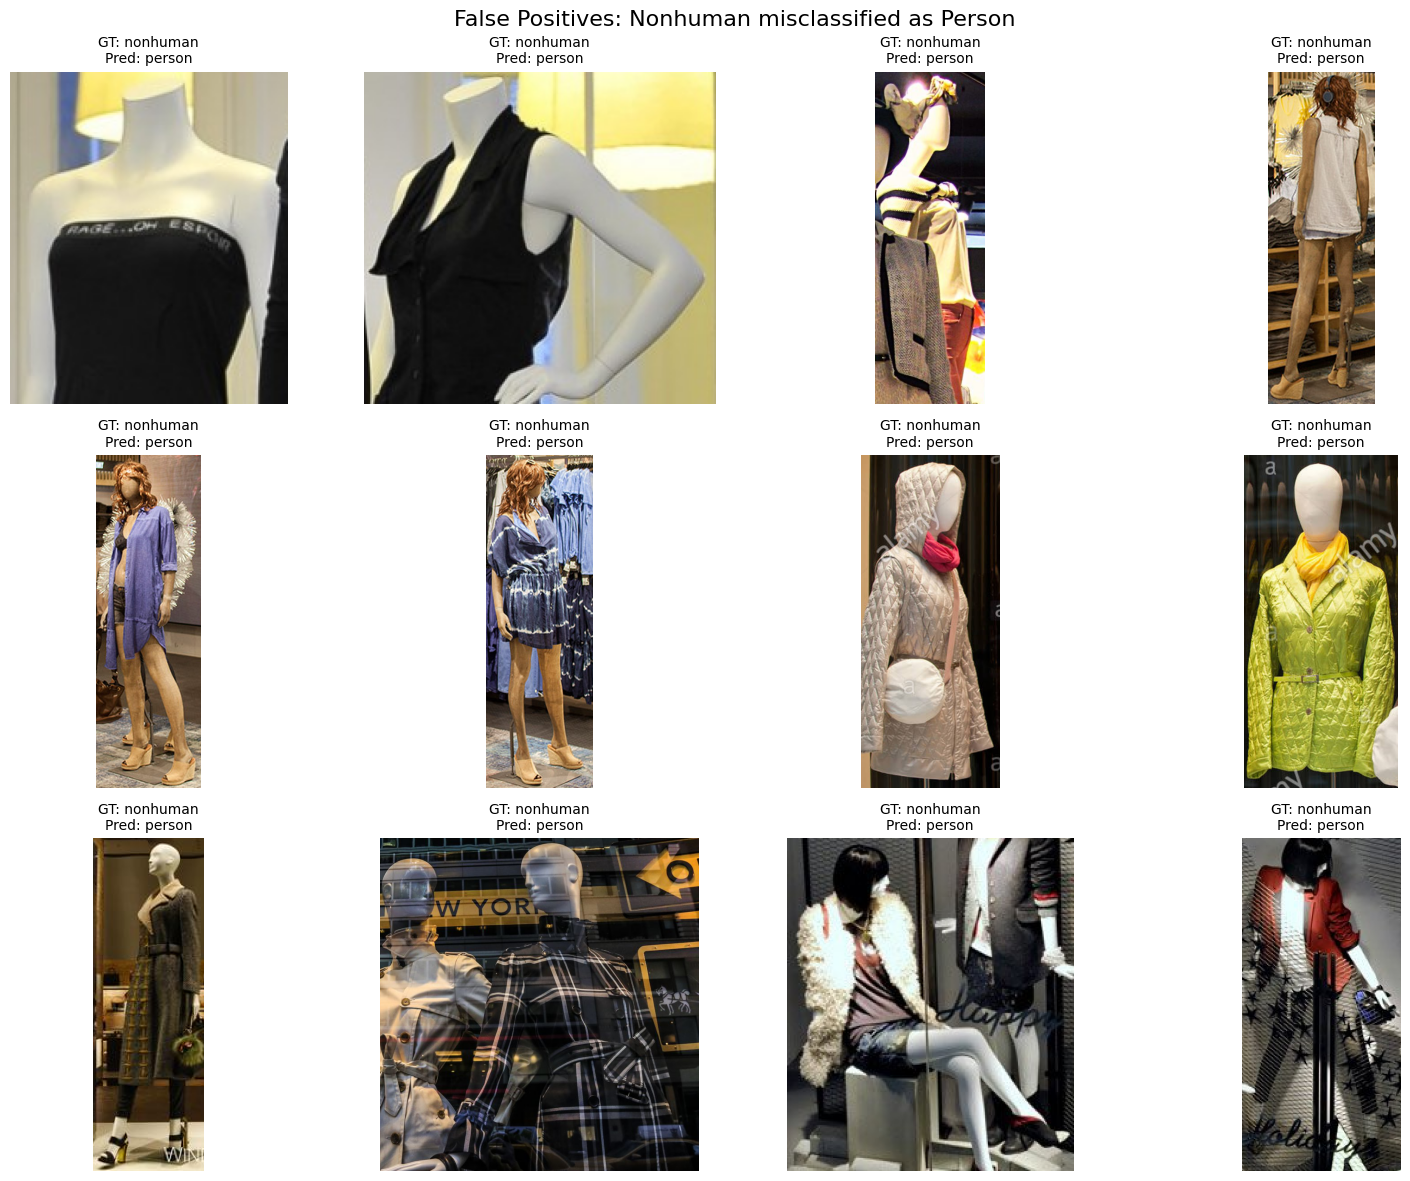

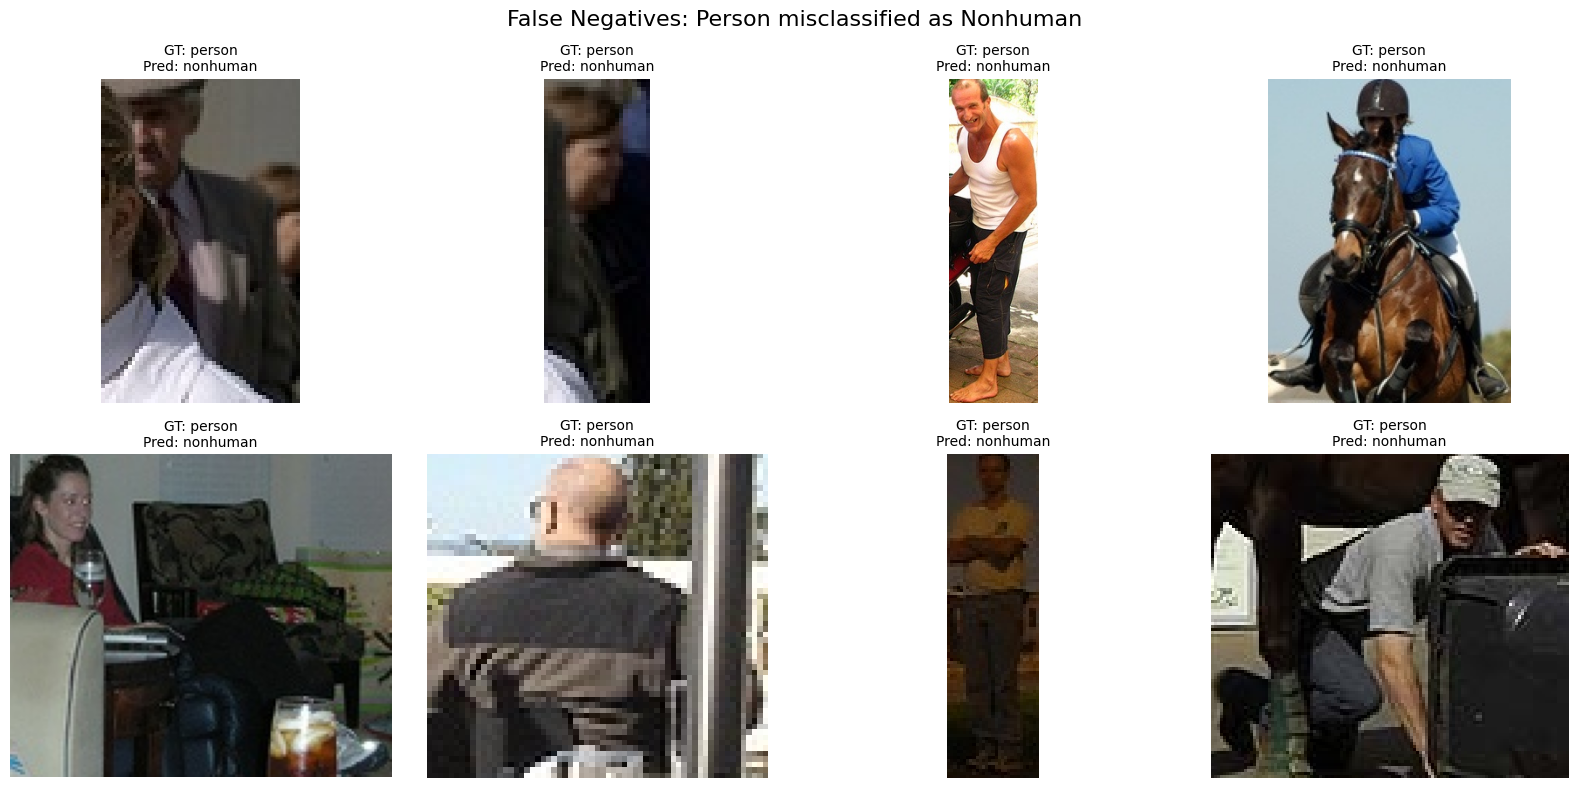

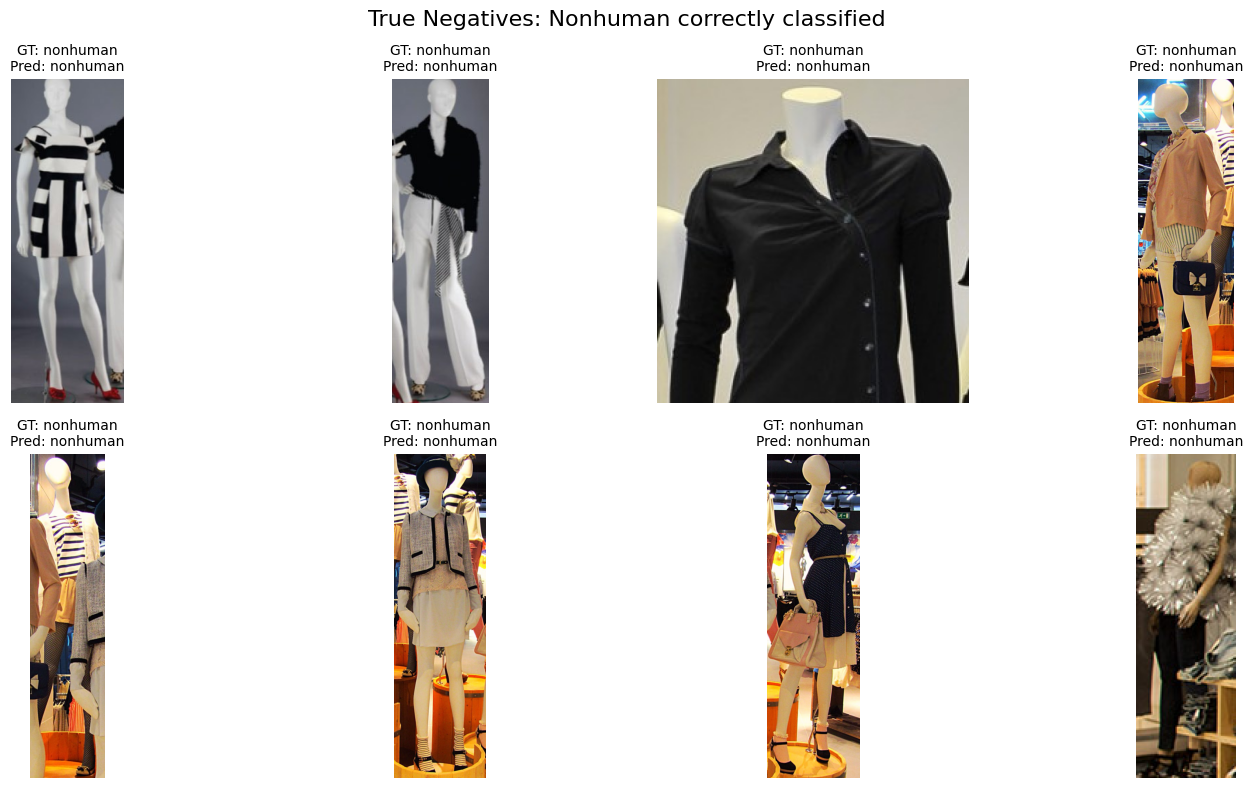

In [60]:
# Booleans for each category
tp_idx = np.where((y_vis == 1) & (y_pred_vis == 1))[0]  # person → person
fp_idx = np.where((y_vis == 0) & (y_pred_vis == 1))[0]  # nonhuman → person  (false positives)
fn_idx = np.where((y_vis == 1) & (y_pred_vis == 0))[0]  # person → nonhuman  (false negatives)
tn_idx = np.where((y_vis == 0) & (y_pred_vis == 0))[0]  # nonhuman → nonhuman

print("TP count:", len(tp_idx))
print("FP count:", len(fp_idx))
print("FN count:", len(fn_idx))
print("TN count:", len(tn_idx))

# Visualize – tweak max_n if you want more/less examples per set
show_crops(tp_idx, "True Positives: Person correctly classified", max_n=8)
show_crops(fp_idx, "False Positives: Nonhuman misclassified as Person", max_n=12)
show_crops(fn_idx, "False Negatives: Person misclassified as Nonhuman", max_n=8)
show_crops(tn_idx, "True Negatives: Nonhuman correctly classified", max_n=8)
